In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from sklearn.metrics import classification_report
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from scores import score_in_details
import torch_directml

In [2]:
dml = torch_directml.device()

In [3]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor(),
])

In [6]:
class MyDataset(Dataset):
    def __init__(self, ds, transform):
        self.ds = ds
        self.transform = transform
                
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):            
        image_path = self.ds[idx][0]
        label = self.ds[idx][1]
        img = cv2.imread(image_path)
        img = self.transform(img)
            
        return {"image": img,
                "labels": label,
                "path": image_path}

In [7]:
dataset_path = "../splitted/test"
test_dataset = dsets.ImageFolder(root=f'{dataset_path}')
test_ds = MyDataset(ds=test_dataset.imgs, transform=transform)

In [8]:
test_loader = DataLoader(test_ds, batch_size=10, drop_last=True, shuffle=False)

In [9]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv =  nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1, padding=0, bias=True),
                     nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                                   
                     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=0, bias=True),
                     nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                                   
                     nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=0, bias=True),
                     nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=0),
                                   
                     nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding=0, bias=True),
                     nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                     nn.MaxPool2d(kernel_size=3, stride=2, padding=0))

        
        self.dense = nn.Sequential(nn.Flatten(), 
                                   nn.Linear(512*11*11, 512),
                                   nn.ReLU(),
                                   nn.Linear(512, 256),
                                   nn.ReLU(),
                                   nn.Linear(256, 2))
                        
    def forward(self, x):
        x = self.conv(x)
        x = self.dense(x)
        
        return x

In [10]:
base_model = MyCNN().to(dml)
model_path = "../trained-models/custom_cnn.pt"
base_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
def get_predictions():
    softmax = nn.Softmax(dim=1)
    base_model.eval()
    predictions = []
    real_values = []
    pred_probas = []
    misclassified = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs = batch['image'].to(dml)
            labels = batch['labels'].to(dml)
            path = batch["path"]
            
            outputs = softmax(base_model(inputs))
            
            _, preds = torch.max(outputs, dim = 1)
            for probs in outputs.cpu():   
                pred_probas.append(list(probs))
            preds = preds.cpu()
            labels = labels.cpu()
            predictions.extend(preds)
            real_values.extend(labels)
            
            for ind, (actual, pred) in enumerate(zip(labels, preds)):
                if actual != pred:
                    misclassified.append((path[ind], actual, pred))
            
    return predictions, real_values, pred_probas, misclassified

In [12]:
pred, real, probas, misclassified = get_predictions()
print(classification_report(real, pred, digits=6))

  0%|          | 0/1886 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0   0.959936  0.968318  0.964109      4924
           1   0.988771  0.985720  0.987244     13936

    accuracy                       0.981177     18860
   macro avg   0.974353  0.977019  0.975676     18860
weighted avg   0.981243  0.981177  0.981203     18860



Accuracy: 98.11770943796394%
Precision: 0.9812428386639696
Recall: 0.9811770943796394
F1-score: 0.9812034674893609
MCC-score: 0.9513691521298455
ROC AUC score: 0.6824694891629461




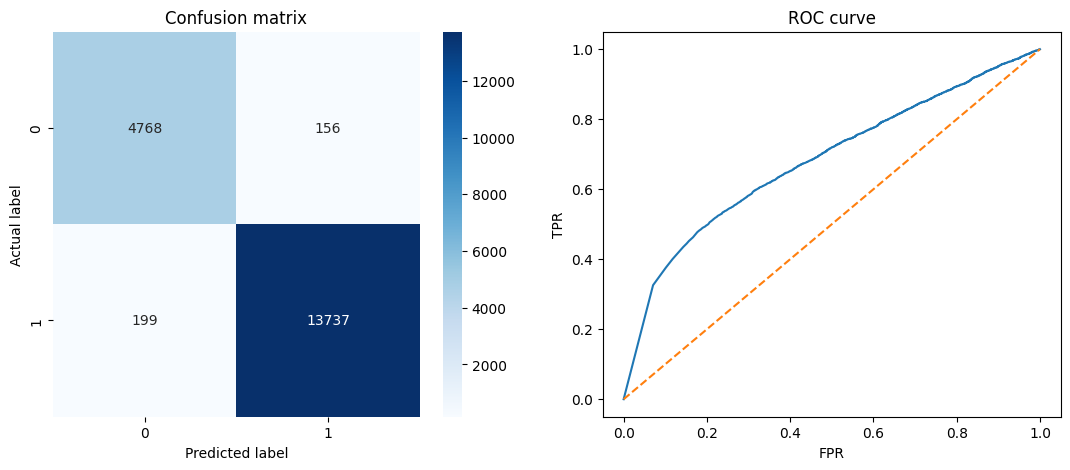

In [14]:
score_in_details(pred=pred, real=real, probas=probas)